In [1]:
%load_ext autoreload
%autoreload 2

[   584.49369369  28753.27160494 124798.875     ]


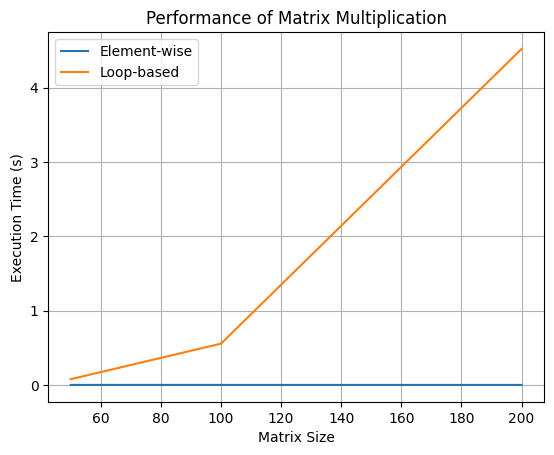

In [6]:
import numpy as np
import time
import matplotlib.pyplot as plt

def matrix_multiply_elementwise(A, B):
    return np.multiply(A, B)

def matrix_multiply_loop(A, B):
    rows_A, cols_A = A.shape
    cols_B = B.shape[1]
    C = np.zeros((rows_A, cols_B))
    for i in range(rows_A):
        for j in range(cols_B):
            for k in range(cols_A):
                C[i][j] += A[i][k] * B[k][j]
    return C

matrix_sizes = [50, 100, 200]
execution_times_elementwise = []
execution_times_loop = []

for size in matrix_sizes:
    A = np.random.rand(size, size)
    B = np.random.rand(size, size)
    
    start_time = time.time()
    matrix_multiply_elementwise(A, B)
    end_time = time.time()
    execution_times_elementwise.append(end_time - start_time)
    
    start_time = time.time()
    matrix_multiply_loop(A, B)
    end_time = time.time()
    execution_times_loop.append(end_time - start_time)


[   584.49369369  28753.27160494 124798.875     ]


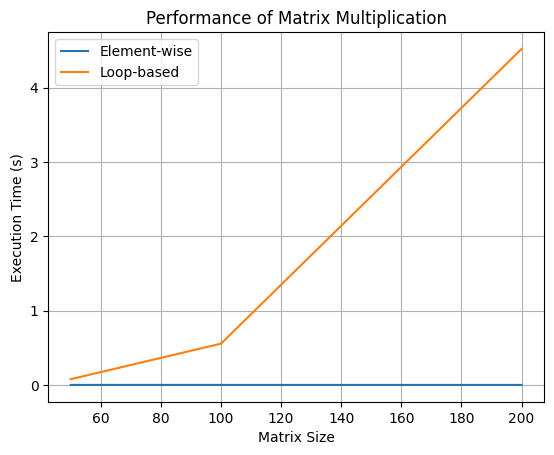

In [7]:

plt.plot(matrix_sizes, execution_times_elementwise, label='Element-wise')
plt.plot(matrix_sizes, execution_times_loop, label='Loop-based')
print(np.asarray(execution_times_loop) / np.asarray(execution_times_elementwise))
plt.xlabel('Matrix Size')
plt.ylabel('Execution Time (s)')
plt.title('Performance of Matrix Multiplication')
plt.legend()
plt.grid(True)
plt.savefig('performance_graph.png')
plt.show()

In [2]:
from cudams.utils import \
    argbatch, mkdir, get_ref_spectra_from_df
import math
from pathlib import Path
import pandas as pd
from itertools import product
from time import perf_counter
from multiprocessing.pool import ThreadPool
from multiprocessing import shared_memory
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
import cupy as cp

cp.cuda.is_available()

True

In [4]:
## Define constants
tolerance: float = 0.1
shift: float = 0
mz_power: float = 0
int_power: float = 1

## How many pairs per batch. Has to be a power of 2.
# Hardware specific - An RTX2070 works best at around 1024 * 2
# But Colab T4 GPU might work best at 1024 * 4
BATCH_SIZE = 2048

# MAX NUMBER OF PEAKS during filtering. Due to nature of matrices, having large number of 
# peaks will increase memory requirements. After 1024, this has diminishing benefits, as 
# smaller and smaller (likely noisy) peaks are taken into consideration when running similarity.
MAX_PEAKS = 1024

# MATCH_LIMIT specifies max how many mz-mz pairs we could consider for each RQ pair, before we sort and filter. 
# E.g. a value of 256 usually causes around ~0.003% of RQ pairs to "overflow".
# The overflown RQ scores will be strictly less than or equal to perfectly accurate score.
# The mean absolute difference at 256, for all overflown pairs is on the order of ~1e-3
# Small values of MATCH_LIMIT (e.g. 128, 64,) cause a dramatic speedup in the processing speed.
MATCH_LIMIT = 1024

# Since Greedy cosine is an unstable algorithm, because approximate mz-mz values do not
# result in approximately the same scores and number of matches.
# So we need to use fp64 to minimize the deviation as much as possible.
# Using float32 causes a significant speedup in the processing speed.
dtype = 'float32'

# Data path
reference_csv_file = Path("data/input/example_dataset_tornike.csv")
query_csv_file = Path("data/input/example_dataset_tornike.csv")

In [5]:
from cudams.utils import get_spectra_batches

len_spectra = 1024
references, queries, batches_inputs = get_spectra_batches(
    batch_size=BATCH_SIZE,
    max_peaks=MAX_PEAKS,
    max_pairs=16 * (BATCH_SIZE ** 2), # 16 batches, give or take...
    padding=len_spectra,
)
TOTAL_BATCHES = len(batches_inputs)
batch_outputs = np.empty(shape=(TOTAL_BATCHES,4),dtype=object)

100%|██████████| 16384/16384 [00:05<00:00, 3138.07it/s]


In [14]:
# from cudams.similarity.kernels import cosine_greedy_kernel

# n_kernel = compile_cuda_cosine_greedy_kernel(
#     tolerance=tolerance,
#     shift=shift,
#     mz_power=mz_power,
#     int_power=int_power,
#     match_limit=MATCH_LIMIT,
#     batch_size=BATCH_SIZE
# )

kernel = cp.RawKernel(
    f"""
    #define R {BATCH_SIZE}
    #define Q {BATCH_SIZE}
    #define MATCH_LIMIT {MATCH_LIMIT}
    #define tolerance {tolerance}
    #define shift {shift}
    #define len_spectra {len_spectra}
    #define int_power {int_power}
    #define mz_power {mz_power}
    """ r"""
    __device__ inline int ix2(const int i, const int j) { return i + R * j; }
    
    extern "C" __global__
    void kernel(
        const float*  rmz,
        const float*  rint,
        
        const float*  qmz,
        const float*  qint,
        
        const int*  rlen,
        const int*  qlen,
        
        float*  scores,
        int*  used_matches,
        char*  overflow
    ) {
        // We imagine x axis as references and y axis as queries
        const int i = blockIdx.y * blockDim.y + threadIdx.y;
        const int j = blockIdx.x * blockDim.x + threadIdx.x;
        
        const int ix_out = i * R + j;
        
        int thread_i = threadIdx.x;
        int thread_j = threadIdx.y;
        int block_size_x = blockDim.x;
        int block_size_y = blockDim.y;
        
        if (i < R && j < Q) {
            overflow[ix_out] = 0;
            scores[ix_out] = 0;
            used_matches[ix_out] = 0;
            // return;
            
            // rmz = rspec[0] rmz shape is [R, C]
            // rint = rspec[1] 
            // qmz = qspec[0]  qmz shape is [Q, C]
            // qint = qspec[1]
            
            // rlen = lens[0]
            // qlen = lens[1]

            const auto rleni = rlen[i]; 
            const auto qlenj = qlen[j];
            
            if (rleni == 0 || qlenj == 0) {
                return;
            }
            
            const auto spec1_mz = rmz + i * len_spectra; // [C]
            const auto spec1_int = rint + i * len_spectra; // [C]
            
            const auto spec2_mz = qmz + j * len_spectra; // [C] have to take an index, not value, because 
            const auto spec2_int = qint + j * len_spectra; // [C] cuda doesn't allow 2d arrays
            
            int lowest_idx = 0;
            int num_match = 0;
            
            int matches[2][MATCH_LIMIT];
            for (int peak1_idx = 0; peak1_idx < rleni; peak1_idx++) {
                
                const auto mz = spec1_mz[peak1_idx];
                const auto low_bound = mz - tolerance;
                const auto high_bound = mz + tolerance;
                
                for (int peak2_idx = lowest_idx; peak2_idx < qlenj; peak2_idx++) {
                    const auto mz2 = spec2_mz[peak2_idx] + shift;
                    if (mz2 > high_bound) {
                        break;
                    } 
                    if (mz2 < low_bound) {
                        lowest_idx = peak2_idx + 1;
                    } else {
                        if (num_match < MATCH_LIMIT) {
                            matches[0][num_match] = peak1_idx;
                            matches[1][num_match] = peak2_idx;
                            num_match++;
                        } else {
                            overflow[ix_out] = 1;
                            break;
                        }
                    }
                }
            }
            
            /* debug checkpoint */
            // used_matches[ix_out] = num_match;
            // return;
            
            if (num_match == 0) {
                return;
            }
            
            float score_norm = 1.0;
            float score_norm_spec1 = 0.0;
            float score_norm_spec2 = 0.0;
            
            for (int peak1_idx = 0; peak1_idx < rleni; ++peak1_idx) {
                score_norm_spec1 += (
                    pow(spec1_mz[peak1_idx], 2 * mz_power) * 
                    pow(spec1_int[peak1_idx], 2 * int_power)
                );
            }
            
            for (int peak2_idx = 0; peak2_idx < qlenj; ++peak2_idx) {
                score_norm_spec2 += (
                    pow(spec2_mz[peak2_idx], 2 * mz_power) * 
                    pow(spec2_int[peak2_idx], 2 * int_power)
                );
            }
            
            score_norm = sqrt(score_norm_spec1) * sqrt(score_norm_spec2);
            
            /* debugging checkpoint */
            // scores[ix_out] = score_norm; 
            // used_matches[ix_out] = num_match;
            // return;
            
            float score = 0;
            int used_match = 0;
            for (int z = 0; z < num_match; z++) {
                float max_prod = -1;
                int max_peak1_idx;
                int max_peak2_idx;
                
                for (int sj = 0; sj < num_match; sj++) {
                    if (matches[0][sj] != -1) {
                        const auto peak1_idx = matches[0][sj];
                        const auto peak2_idx = matches[1][sj];
                        
                        const auto power_prod_spec1 = (
                            pow(spec1_mz[peak1_idx], mz_power) * 
                            pow(spec1_int[peak1_idx], int_power)
                        );
                        
                        const auto power_prod_spec2 = (
                            pow(spec2_mz[peak2_idx], mz_power) * 
                            pow(spec2_int[peak2_idx], int_power)
                        );
                        
                        const auto prod = power_prod_spec1 * power_prod_spec2;
                        
                        if (prod > max_prod) {
                            max_prod = prod;
                            max_peak1_idx = peak1_idx;
                            max_peak2_idx = peak2_idx;
                        }
                    }
                }
                
                /* debug checkpoint */
                // scores[ix_out] = max_prod;
                // used_matches[ix_out] = used_match;
                // return;
                
                if (max_prod != -1) {
                    for (int sj = 0; sj < num_match; sj++) {
                        if (
                            matches[0][sj] == max_peak1_idx
                            || matches[1][sj] == max_peak2_idx
                        ) {
                            matches[0][sj] = -1;
                            matches[1][sj] = -1;
                        }
                    }
                    score += max_prod;
                    used_match++;
                } else {
                    break;
                }
            }
            /* debug checkpoint */
            // scores[ix_out] = score_norm; // Pass
            // used_matches[ix_out] = used_match;
            // return;
            
            // scores[ix_out] = matches[0][MATCH_LIMIT-1];
            // used_matches[ix_out] = matches[1][MATCH_LIMIT-1];
            
            // scores[ix_out] = matches[0][0];
            // used_matches[ix_out] = matches[1][0];
            // return;
            
            score = score / score_norm;
            
            scores[ix_out] = score;
            used_matches[ix_out] = used_match;
        }
    }
    """,
    'kernel',
    backend='nvcc',
    options=(
        "-std=c++11",
        "-use_fast_math",
        "-lineinfo",
        "-Xptxas",
        "-v -warn-spills -warn-lmem-usage",
    ),
)


In [15]:
R, Q = BATCH_SIZE, BATCH_SIZE
THREADS_PER_BLOCK = (32, 32)
BLOCKS_PER_GRID_X = math.ceil(R / THREADS_PER_BLOCK[0])
BLOCKS_PER_GRID_Y = math.ceil(Q / THREADS_PER_BLOCK[1])
BLOCKS_PER_GRID = (BLOCKS_PER_GRID_X, BLOCKS_PER_GRID_Y)

for batch_i in tqdm(range(TOTAL_BATCHES)):
        # We get our batch and lengths (lengths are different for different spectra)
    (rspec, rlen, rstart, rend), (qspec, qlen, qstart, qend) = batches_inputs[
        batch_i
    ]
    
    lens = np.zeros((2, BATCH_SIZE), "int32")
    lens[0, :len(rlen)] = rlen
    lens[1, :len(qlen)] = qlen
    
    # We order empty space for results on GPU RAM
    scores = cp.zeros(
        (BATCH_SIZE, BATCH_SIZE), dtype="float32"
    )
    used_matches = cp.zeros(
        (BATCH_SIZE, BATCH_SIZE), dtype="int32"
    )
    overflow = cp.zeros(
        (BATCH_SIZE, BATCH_SIZE), dtype="uint8"
    )

    rmz = cp.asarray(rspec[0])
    rint = cp.asarray(rspec[1])
    
    qmz = cp.asarray(qspec[0])
    qint = cp.asarray(qspec[1])
    
    rlen = cp.asarray(lens[0])
    qlen = cp.asarray(lens[1])
    
    # rnorm = ((rmz ** mz_power) * (rint ** int_power)).sum()
    
    kernel(
        BLOCKS_PER_GRID, 
        THREADS_PER_BLOCK,
        (
            rmz,
            rint,
            
            qmz,
            qint,
            
            rlen,
            qlen,
            
            scores,
            used_matches,
            overflow,
        )
    )
    scores.get()
    
    # break
# plt.imshow(scores.get())

100%|██████████| 16/16 [00:08<00:00,  1.89it/s]
